# **Measurements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

import tools
import simulation.simulator as simulator
import measurement
import meeting_model
import metrics
import movement_tracker
import tell_decisions

import sumolib

reload(movement_tracker)
reload(tell_decisions)
reload(metrics)
reload(simulator)

<module 'simulation.simulator' from '/home/levente/Egyetem/PhD/kutatas/pards/src/simulation/simulator.py'>

## **Initialization steps**
### Loading the SUMO network and constructing the MC

In [2]:
P, edge_to_index_map, index_to_edge_map = tools.utils.read_MC("../data/large_grid2.net.xml",
                                                       "../data/turnings.xml",
                                                       [.15, .8, .05])
net = sumolib.net.readNet("../data/large_grid2.net.xml")
P_ = tools.mc.add_st_node(P, [0.0, 0.0])
π = tools.mc.calculate_stationary_distribution(P_)#[:-1]/np.sum(tools.mc.calculate_stationary_distribution(P_)[:-1])
P_b = tools.mc.calculate_time_reversed_mc(P_, π)

matrix_power = tools.utils.MatrixPower(P_b)

initial_state_model = π

### Creating the route length model

In [3]:
def sample_route_lengths(a, num_samples):
    p_m = 1/a
    ds = np.arange(1, 2*a+1)
    return np.array([2*p_m/a*d if d<=a/2 else -2*p_m/(3*a)*d+4/3*p_m for d in ds])

### Defining the callback function

In [4]:
class MeasCallback:
       

    
    
    def __init__(self, net, P_b, edge_to_index_map, index_to_edge_map,
                 st_dist, matrix_power,
                 p_length):
        '''
            Parameters:
                net: SUMO road network
                P_b: backward transition matrix of the Markov Chain
                edge_to_index_map: network edges -> indices of P
                index_to_edge_map: indices of P -> network edges
                st_dist: stationary distribution of the _forward_ Markov Chain
                matrix_power: matrix poewring object
                p_length: route length model
        '''
        self.net = net
        self.meeting_model = meeting_model.Meeting(edge_to_index_map, index_to_edge_map)
        self.P = P_b
        self.st_dist = st_dist
        self.matrix_power = matrix_power
        self.index_to_edge_map = index_to_edge_map
        self.p_length = p_length
        
        self.movement_tracker = movement_tracker.MovementTracker()
        
        self.received_information_uniform = {}
        self.received_information_minprob = {}
        self.received_information_last1 = {}
        self.received_information_last2 = {}
        self.received_information_last3 = {}
        self.received_information_mix = {}
        
        self.distances = {}
        
        
    def _store_distances(self, t, sender_id, sent_routes, true_starting_edge, n=10):
        '''
            Stores the correctness (i.e. reconstruction distances) of alter. This can be
            seen as the privacy loss of ego.
            Parameters:
                t: timestep
                sender_id: id of the sender vehicle (ego)
                sent_route: list of lists of the sent edges per measurement cases
                   (in order of time, i.e. sent_route[0] is the firstly edge
                   visited, sent_route[-1] is the point of sharing)
                true_starting_edge: origin of the sender vehicle (ego)
                n: number of most probable edges
            Stores:
                distances[id][t][x] refers to the top n distances of the given vehicle id
                shared at timestep t. x iterates through the telling methods
        '''
        distances = []
        for route in sent_routes:
            dist_ = metrics.calculate_correctness_best_n(self.net, self.index_to_edge_map,
                                                             self.matrix_power,
                                                             self.P, route, self.p_length,
                                                             true_starting_edge,
                                                             n=n)
            distances.append(dist_)
            
        if not(sender_id in self.distances):
            self.distances[sender_id] = {}  
        self.distances[sender_id][t] = distances


        
    def _share_information(self, t, ids, routes):
        '''
            This method handles the information sharing among two vehicles.
            Parameters:
                t: timestep
                ids: ids of the two vehicles
                routes: routes of the vehicles
        '''
        assert (len(ids) == 2) and (len(routes) == 2)
        
        #calculating the amount of shared information:
        uniform = [[],[]]
        minprob = [[],[]]
        last1   = [[],[]]
        last2   = [[],[]]
        last3   = [[],[]]
        mix     = [[],[]]
        for i,_id in enumerate(ids):
            uniform[i]= tell_decisions.tell_uniform(self.P, routes[i])
            minprob[i]= tell_decisions.tell_min_prob(self.P, routes[i], self.st_dist, self.matrix_power)
            last1[i]= tell_decisions.tell_last_n(self.P, routes[i], 1)
            last2[i]= tell_decisions.tell_last_n(self.P, routes[i], 2)
            last3[i]= tell_decisions.tell_last_n(self.P, routes[i], 3)
            mix[i]= tell_decisions.tell_mix(self.P, routes[i], self.st_dist, self.matrix_power, 1)
            
        #print(uniform[i],"\n", minprob[i], "\n", last1[i])
        
        #storing results:
        for i,_id in enumerate(ids):
            if not(_id in self.received_information_uniform):
                self.received_information_uniform[_id] = []
                self.received_information_minprob[_id] = []
                self.received_information_last1[_id] = []
                self.received_information_last2[_id] = []
                self.received_information_last3[_id] = []
                self.received_information_mix[_id] = []
            #stroring results, note that the calculated shared information of ego vehicle is the received information by alter
            self.received_information_uniform[_id] = self.received_information_uniform[_id] + uniform[i-1]
            self.received_information_minprob[_id] = self.received_information_minprob[_id] + minprob[i-1]
            self.received_information_last1[_id] = self.received_information_last1[_id] + last1[i-1]
            self.received_information_last2[_id] = self.received_information_last2[_id] + last2[i-1]
            self.received_information_last3[_id] = self.received_information_last3[_id] + last3[i-1]
            self.received_information_mix[_id] = self.received_information_mix[_id] + mix[i-1]
            #storing distances = the loss of privacy caused by the sharing:
            self._store_distances(t, _id,
                    [uniform[i-1], minprob[i-1], last1[i-1], last2[i-1], last3[i-1], mix[i-1]],
                                  self.movement_tracker.movements[_id][0])
            
        
    def __call__(self, t, states, ids, remainings):
        if t%20 == 0: print("Step %d"%t)
        self.movement_tracker(t, states, ids, remainings)
        meetings = self.meeting_model(t, states, ids, remainings)
        for x,y in meetings:
            route_x = self.movement_tracker.movements[ids[x]]
            route_y = self.movement_tracker.movements[ids[y]]
            
            #sharing information:
            self._share_information(t, [ids[x],ids[y]], [route_x, route_y]) 

## **Minimal running measurement**

In [5]:
feeding_model = np.ones(30)
path_length_model = sample_route_lengths(20, np.sum(feeding_model))

In [6]:
import time

measurement_tool = MeasCallback(net, P_b, edge_to_index_map, index_to_edge_map,
                                π, matrix_power, path_length_model)
sim = simulator.Simulator(P_, feeding_model, initial_state_model, path_length_model)

start_time = time.time()
run_steps = sim.simulate(callback_function=measurement_tool)
stop_time = time.time()

print("Simulator finished in {} steps, computed in {} seconds".format(run_steps, stop_time-start_time))

Step 0
Step 20
Step 40
Simulator finished in 60 steps, computed in 68.68595314025879 seconds


### Evaluation

In [7]:
iongs_uniform = []
iongs_minprob = []
iongs_last1 = []
iongs_last2 = []
iongs_last3 = []
iongs_mix = []

for _id in measurement_tool.movement_tracker.movements:
    #if a vehicle received information, it gathered additional information:
    if _id in measurement_tool.received_information_uniform:
        iongs_uniform.append(metrics.compute_iong(measurement_tool.movement_tracker.movements[_id],
                                     measurement_tool.received_information_uniform[_id]))
        iongs_minprob.append(metrics.compute_iong(measurement_tool.movement_tracker.movements[_id],
                                     measurement_tool.received_information_minprob[_id]))
        iongs_last1.append(metrics.compute_iong(measurement_tool.movement_tracker.movements[_id],
                                     measurement_tool.received_information_last1[_id]))
        iongs_last2.append(metrics.compute_iong(measurement_tool.movement_tracker.movements[_id],
                                     measurement_tool.received_information_last2[_id]))
        iongs_last3.append(metrics.compute_iong(measurement_tool.movement_tracker.movements[_id],
                                     measurement_tool.received_information_last3[_id]))
        iongs_mix.append(metrics.compute_iong(measurement_tool.movement_tracker.movements[_id],
                                     measurement_tool.received_information_mix[_id]))
    
    else:
        #otherwise, it did not:
        iongs_uniform.append(0)
        iongs_minprob.append(0)
        iongs_last1.append(0)
        iongs_last2.append(0)
        iongs_last3.append(0)
        iongs_mix.append(0)

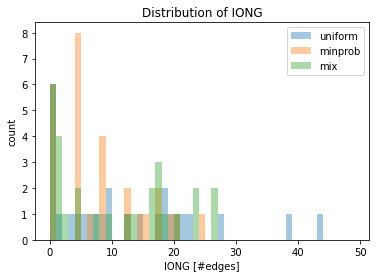

In [8]:
plt.hist(iongs_uniform, bins = range(0, 50), label="uniform", alpha=0.4)
plt.hist(iongs_minprob, bins = range(0, 50), label="minprob", alpha=0.4)
plt.hist(iongs_mix, bins = range(0, 50), label="mix", alpha=0.4)

plt.title("Distribution of IONG")
plt.xlabel("IONG [#edges]")
plt.ylabel("count")
plt.legend()

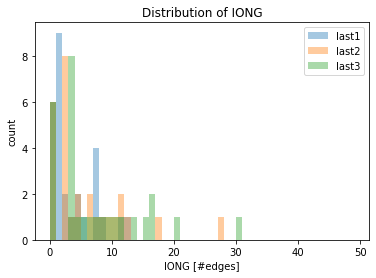

In [9]:
plt.hist(iongs_last1, bins = range(0, 50), label="last1", alpha=0.4)
plt.hist(iongs_last2, bins = range(0, 50), label="last2", alpha=0.4)
plt.hist(iongs_last3, bins = range(0, 50), label="last3", alpha=0.4)

plt.title("Distribution of IONG")
plt.xlabel("IONG [#edges]")
plt.ylabel("count")
plt.legend()

Text(0, 0.5, 'prediction distance [m]')

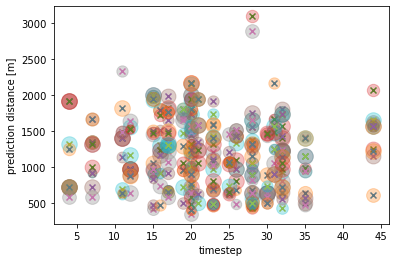

In [24]:
legends = ["uniform", "minprob", "last1", "last2", "last3", "mix"]

for _id in measurement_tool.distances:
    for t in measurement_tool.distances[_id]:
        for dist in measurement_tool.distances[_id][t]:
            dist = np.array(dist)
            plt.scatter(t, np.mean(dist[np.isfinite(dist)]), marker="x", alpha=1.0)
            plt.scatter(t, np.mean(dist[np.isfinite(dist)]), s=np.std(dist[np.isfinite(dist)]), alpha=0.3)

plt.xlabel("timestep")
plt.ylabel("prediction distance [m]")

In [28]:
distances_per_telling = [[] for i in range(len(legends))]
for _id in measurement_tool.distances:
    for t in measurement_tool.distances[_id]:
        for i,dist in enumerate(measurement_tool.distances[_id][t]):
            distances_per_telling[i] = distances_per_telling[i] + dist

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1ea40269b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1ea4026160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1ea4026f28>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1ea4018a20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1ea4026e48>,
 'means': []}

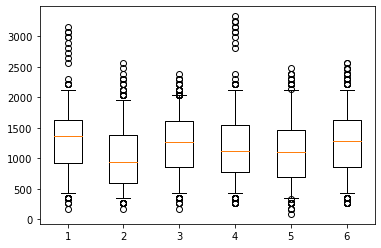

In [30]:
plt.boxplot(distances_per_telling, whis=[5, 95])

<AxesSubplot:xlabel='method', ylabel='Alter correctness\ndistance [m]'>

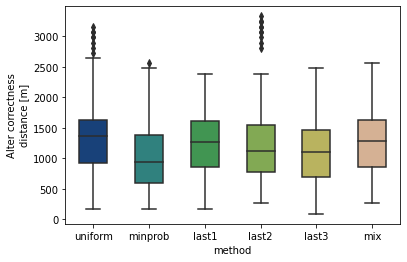

In [43]:
import seaborn as sns
import pandas as pd

data = []
for i, l in enumerate(legends):
    for d in distances_per_telling[i]:
        data.append([l, d])
data = pd.DataFrame(data, columns=["method", "Alter correctness\ndistance [m]"])

sns.boxplot(x="method", y="Alter correctness\ndistance [m]", data=data, palette="gist_earth", width=0.5, saturation=1.0)